Can we back into the same adversary prediction abilities using only the sorted edge weights? I.e. if we just look at the top n edges in the filtration, is this good enough? Or do we actually use persistent homology effectively?

In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.fff_mnist import FFF

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [15]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/lbfgsm/fff_mnist_relu.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_sample_graph(f):
    m = dion.homology_persistence(f)
    dgms = dion.init_diagrams(m,f)
    subgraphs = {}
    for i,c in enumerate(m):
        if len(c) == 2:
#                 print(" + ".join(["%d * %s" % (x.element, f[x.index]) for x in c]))
            if f[c[0].index][0] in subgraphs:
                subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(f[c[0].index][0]):
                        v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                    subgraphs[f[c[0].index][0]] = g

    return subgraphs, dgms[0]


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

In [5]:
def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams

In [8]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/fff_mnist_relu.pt'
model = FFF()
model.load_state_dict(torch.load(model_location))

In [13]:
res_df, sample_graphs, dgms = create_subgraphs(model, 1, 2000)

Filtration: 0
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38878
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50341
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 25824
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 58947
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39986
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 30780
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44041
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42219
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 54534
Sorting filtration...
Filtration: 9
h1_id_start 78

h2_id_start 1040
h3_id_start 1090
filtration size 45202
Sorting filtration...
Filtration: 76
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38746
Sorting filtration...
Filtration: 77
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42675
Sorting filtration...
Filtration: 78
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42421
Sorting filtration...
Filtration: 79
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 58977
Sorting filtration...
Filtration: 80
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38380
Sorting filtration...
Filtration: 81
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49003
Sorting filtration...
Filtration: 82
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55984
Sorting filtration...
Filtration: 83
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36368
Sorting filtration...
Filtration: 84
h1_id_start 784
h2_id_start 1040
h3

h2_id_start 1040
h3_id_start 1090
filtration size 47415
Sorting filtration...
Filtration: 151
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56057
Sorting filtration...
Filtration: 152
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43249
Sorting filtration...
Filtration: 153
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39072
Sorting filtration...
Filtration: 154
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 27476
Sorting filtration...
Filtration: 155
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55575
Sorting filtration...
Filtration: 156
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42803
Sorting filtration...
Filtration: 157
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43187
Sorting filtration...
Filtration: 158
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44503
Sorting filtration...
Filtration: 159
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 50744
Sorting filtration...
Filtration: 226
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61106
Sorting filtration...
Filtration: 227
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34020
Sorting filtration...
Filtration: 228
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 26979
Sorting filtration...
Filtration: 229
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 29742
Sorting filtration...
Filtration: 230
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43691
Sorting filtration...
Filtration: 231
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38635
Sorting filtration...
Filtration: 232
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52045
Sorting filtration...
Filtration: 233
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56660
Sorting filtration...
Filtration: 234
h1_id_start 784
h2_id_star

Filtration: 301
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 54290
Sorting filtration...
Filtration: 302
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 27106
Sorting filtration...
Filtration: 303
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39545
Sorting filtration...
Filtration: 304
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45525
Sorting filtration...
Filtration: 305
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56452
Sorting filtration...
Filtration: 306
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41566
Sorting filtration...
Filtration: 307
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41580
Sorting filtration...
Filtration: 308
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52027
Sorting filtration...
Filtration: 309
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38592
Sorting filtration...
Filtration

h2_id_start 1040
h3_id_start 1090
filtration size 37472
Sorting filtration...
Filtration: 377
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 24472
Sorting filtration...
Filtration: 378
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 28705
Sorting filtration...
Filtration: 379
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42943
Sorting filtration...
Filtration: 380
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52721
Sorting filtration...
Filtration: 381
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41758
Sorting filtration...
Filtration: 382
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47956
Sorting filtration...
Filtration: 383
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 28838
Sorting filtration...
Filtration: 384
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 58379
Sorting filtration...
Filtration: 385
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 57258
Sorting filtration...
Filtration: 452
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42113
Sorting filtration...
Filtration: 453
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51446
Sorting filtration...
Filtration: 454
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43080
Sorting filtration...
Filtration: 455
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 32005
Sorting filtration...
Filtration: 456
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39401
Sorting filtration...
Filtration: 457
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 46968
Sorting filtration...
Filtration: 458
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51900
Sorting filtration...
Filtration: 459
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42834
Sorting filtration...
Filtration: 460
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 49463
Sorting filtration...
Filtration: 527
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 71007
Sorting filtration...
Filtration: 528
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47976
Sorting filtration...
Filtration: 529
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 33504
Sorting filtration...
Filtration: 530
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41937
Sorting filtration...
Filtration: 531
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37964
Sorting filtration...
Filtration: 532
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42645
Sorting filtration...
Filtration: 533
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51130
Sorting filtration...
Filtration: 534
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47549
Sorting filtration...
Filtration: 535
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 46137
Sorting filtration...
Filtration: 602
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61170
Sorting filtration...
Filtration: 603
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47648
Sorting filtration...
Filtration: 604
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47161
Sorting filtration...
Filtration: 605
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43446
Sorting filtration...
Filtration: 606
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51261
Sorting filtration...
Filtration: 607
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47952
Sorting filtration...
Filtration: 608
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52056
Sorting filtration...
Filtration: 609
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41658
Sorting filtration...
Filtration: 610
h1_id_start 784
h2_id_star

Filtration: 676
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50620
Sorting filtration...
Filtration: 677
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 59856
Sorting filtration...
Filtration: 678
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51704
Sorting filtration...
Filtration: 679
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 33724
Sorting filtration...
Filtration: 680
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 53116
Sorting filtration...
Filtration: 681
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52355
Sorting filtration...
Filtration: 682
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 28741
Sorting filtration...
Filtration: 683
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37790
Sorting filtration...
Filtration: 684
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52693
Sorting filtration...
Filtration

Filtration: 751
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 69208
Sorting filtration...
Filtration: 752
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51420
Sorting filtration...
Filtration: 753
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50356
Sorting filtration...
Filtration: 754
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 27162
Sorting filtration...
Filtration: 755
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 24763
Sorting filtration...
Filtration: 756
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38253
Sorting filtration...
Filtration: 757
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38426
Sorting filtration...
Filtration: 758
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43075
Sorting filtration...
Filtration: 759
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40819
Sorting filtration...
Filtration

Filtration: 826
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 30677
Sorting filtration...
Filtration: 827
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40032
Sorting filtration...
Filtration: 828
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48167
Sorting filtration...
Filtration: 829
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48036
Sorting filtration...
Filtration: 830
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40043
Sorting filtration...
Filtration: 831
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 28073
Sorting filtration...
Filtration: 832
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40345
Sorting filtration...
Filtration: 833
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 46113
Sorting filtration...
Filtration: 834
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42769
Sorting filtration...
Filtration

h2_id_start 1040
h3_id_start 1090
filtration size 43401
Sorting filtration...
Filtration: 902
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40910
Sorting filtration...
Filtration: 903
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 64918
Sorting filtration...
Filtration: 904
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 57887
Sorting filtration...
Filtration: 905
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55103
Sorting filtration...
Filtration: 906
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49324
Sorting filtration...
Filtration: 907
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 26842
Sorting filtration...
Filtration: 908
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38323
Sorting filtration...
Filtration: 909
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34630
Sorting filtration...
Filtration: 910
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 43517
Sorting filtration...
Filtration: 977
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 35092
Sorting filtration...
Filtration: 978
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44516
Sorting filtration...
Filtration: 979
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 32533
Sorting filtration...
Filtration: 980
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43350
Sorting filtration...
Filtration: 981
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55717
Sorting filtration...
Filtration: 982
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48710
Sorting filtration...
Filtration: 983
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47088
Sorting filtration...
Filtration: 984
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 23461
Sorting filtration...
Filtration: 985
h1_id_start 784
h2_id_star

h2_id_start 1040
h3_id_start 1090
filtration size 49198
Sorting filtration...
Filtration: 1052
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 62314
Sorting filtration...
Filtration: 1053
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61120
Sorting filtration...
Filtration: 1054
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 29321
Sorting filtration...
Filtration: 1055
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38384
Sorting filtration...
Filtration: 1056
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43797
Sorting filtration...
Filtration: 1057
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43777
Sorting filtration...
Filtration: 1058
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37147
Sorting filtration...
Filtration: 1059
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 54628
Sorting filtration...
Filtration: 1060
h1_id_start 784
h

h2_id_start 1040
h3_id_start 1090
filtration size 43383
Sorting filtration...
Filtration: 1126
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44418
Sorting filtration...
Filtration: 1127
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48576
Sorting filtration...
Filtration: 1128
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 64530
Sorting filtration...
Filtration: 1129
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38443
Sorting filtration...
Filtration: 1130
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 54078
Sorting filtration...
Filtration: 1131
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48246
Sorting filtration...
Filtration: 1132
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52519
Sorting filtration...
Filtration: 1133
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39584
Sorting filtration...
Filtration: 1134
h1_id_start 784
h

h2_id_start 1040
h3_id_start 1090
filtration size 53744
Sorting filtration...
Filtration: 1200
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43300
Sorting filtration...
Filtration: 1201
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 31708
Sorting filtration...
Filtration: 1202
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56895
Sorting filtration...
Filtration: 1203
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 69669
Sorting filtration...
Filtration: 1204
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47919
Sorting filtration...
Filtration: 1205
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43385
Sorting filtration...
Filtration: 1206
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45406
Sorting filtration...
Filtration: 1207
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47429
Sorting filtration...
Filtration: 1208
h1_id_start 784
h

h2_id_start 1040
h3_id_start 1090
filtration size 60876
Sorting filtration...
Filtration: 1274
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 31908
Sorting filtration...
Filtration: 1275
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 35159
Sorting filtration...
Filtration: 1276
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51824
Sorting filtration...
Filtration: 1277
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43550
Sorting filtration...
Filtration: 1278
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51532
Sorting filtration...
Filtration: 1279
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39882
Sorting filtration...
Filtration: 1280
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 24799
Sorting filtration...
Filtration: 1281
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56975
Sorting filtration...
Filtration: 1282
h1_id_start 784
h

Filtration: 1348
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 62940
Sorting filtration...
Filtration: 1349
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43821
Sorting filtration...
Filtration: 1350
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 30506
Sorting filtration...
Filtration: 1351
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37869
Sorting filtration...
Filtration: 1352
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 79067
Sorting filtration...
Filtration: 1353
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43006
Sorting filtration...
Filtration: 1354
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 53040
Sorting filtration...
Filtration: 1355
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 32609
Sorting filtration...
Filtration: 1356
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41650
Sorting filtration...
F

h2_id_start 1040
h3_id_start 1090
filtration size 56444
Sorting filtration...
Filtration: 1423
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51356
Sorting filtration...
Filtration: 1424
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 31441
Sorting filtration...
Filtration: 1425
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61062
Sorting filtration...
Filtration: 1426
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45601
Sorting filtration...
Filtration: 1427
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48831
Sorting filtration...
Filtration: 1428
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55769
Sorting filtration...
Filtration: 1429
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43276
Sorting filtration...
Filtration: 1430
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 28107
Sorting filtration...
Filtration: 1431
h1_id_start 784
h

h3_id_start 1090
filtration size 36228
Sorting filtration...
Filtration: 1497
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43888
Sorting filtration...
Filtration: 1498
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52812
Sorting filtration...
Filtration: 1499
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61852
Sorting filtration...
Filtration: 1500
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 30994
Sorting filtration...
Filtration: 1501
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49805
Sorting filtration...
Filtration: 1502
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 46487
Sorting filtration...
Filtration: 1503
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34380
Sorting filtration...
Filtration: 1504
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49412
Sorting filtration...
Filtration: 1505
h1_id_start 784
h2_id_start 1040
h

h2_id_start 1040
h3_id_start 1090
filtration size 54191
Sorting filtration...
Filtration: 1571
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41971
Sorting filtration...
Filtration: 1572
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52163
Sorting filtration...
Filtration: 1573
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48836
Sorting filtration...
Filtration: 1574
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 59362
Sorting filtration...
Filtration: 1575
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 53323
Sorting filtration...
Filtration: 1576
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 35483
Sorting filtration...
Filtration: 1577
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45346
Sorting filtration...
Filtration: 1578
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41511
Sorting filtration...
Filtration: 1579
h1_id_start 784
h

h2_id_start 1040
h3_id_start 1090
filtration size 40113
Sorting filtration...
Filtration: 1645
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50483
Sorting filtration...
Filtration: 1646
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34038
Sorting filtration...
Filtration: 1647
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40121
Sorting filtration...
Filtration: 1648
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36397
Sorting filtration...
Filtration: 1649
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47742
Sorting filtration...
Filtration: 1650
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55150
Sorting filtration...
Filtration: 1651
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45342
Sorting filtration...
Filtration: 1652
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 35918
Sorting filtration...
Filtration: 1653
h1_id_start 784
h

Filtration: 1719
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49701
Sorting filtration...
Filtration: 1720
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 60993
Sorting filtration...
Filtration: 1721
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39674
Sorting filtration...
Filtration: 1722
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38054
Sorting filtration...
Filtration: 1723
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 61968
Sorting filtration...
Filtration: 1724
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50840
Sorting filtration...
Filtration: 1725
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 35089
Sorting filtration...
Filtration: 1726
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 57720
Sorting filtration...
Filtration: 1727
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50419
Sorting filtration...
F

h2_id_start 1040
h3_id_start 1090
filtration size 56051
Sorting filtration...
Filtration: 1794
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45514
Sorting filtration...
Filtration: 1795
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48214
Sorting filtration...
Filtration: 1796
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51552
Sorting filtration...
Filtration: 1797
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50491
Sorting filtration...
Filtration: 1798
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52893
Sorting filtration...
Filtration: 1799
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37663
Sorting filtration...
Filtration: 1800
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 46090
Sorting filtration...
Filtration: 1801
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 63774
Sorting filtration...
Filtration: 1802
h1_id_start 784
h

h3_id_start 1090
filtration size 29438
Sorting filtration...
Filtration: 1868
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34038
Sorting filtration...
Filtration: 1869
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42205
Sorting filtration...
Filtration: 1870
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 63228
Sorting filtration...
Filtration: 1871
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 60395
Sorting filtration...
Filtration: 1872
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43900
Sorting filtration...
Filtration: 1873
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47852
Sorting filtration...
Filtration: 1874
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43123
Sorting filtration...
Filtration: 1875
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40581
Sorting filtration...
Filtration: 1876
h1_id_start 784
h2_id_start 1040
h

Filtration: 1942
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37215
Sorting filtration...
Filtration: 1943
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40142
Sorting filtration...
Filtration: 1944
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 58830
Sorting filtration...
Filtration: 1945
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36978
Sorting filtration...
Filtration: 1946
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40367
Sorting filtration...
Filtration: 1947
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 53049
Sorting filtration...
Filtration: 1948
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40383
Sorting filtration...
Filtration: 1949
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48129
Sorting filtration...
Filtration: 1950
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36135
Sorting filtration...
F

In [16]:
adv_df, adv_sample_graphs, adv_dgms = create_adversary_subgraphs(model, 1, 2000, adversaries)

torch.Size([3000, 1, 28, 28]) torch.Size([3000])
Filtration: 0
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 81947
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50341
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 149010
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 148963
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 80242
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 103014
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 117333
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 89747
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 545

Filtration: 75
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 151323
Sorting filtration...
Filtration: 76
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38746
Sorting filtration...
Filtration: 77
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42675
Sorting filtration...
Filtration: 78
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 114778
Sorting filtration...
Filtration: 79
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 146921
Sorting filtration...
Filtration: 80
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 85044
Sorting filtration...
Filtration: 81
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 149300
Sorting filtration...
Filtration: 82
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55984
Sorting filtration...
Filtration: 83
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 136157
Sorting filtration...
Filtration: 84

Filtration: 150
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 129608
Sorting filtration...
Filtration: 151
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 141121
Sorting filtration...
Filtration: 152
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43249
Sorting filtration...
Filtration: 153
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39072
Sorting filtration...
Filtration: 154
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 64664
Sorting filtration...
Filtration: 155
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55575
Sorting filtration...
Filtration: 156
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 101993
Sorting filtration...
Filtration: 157
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 136631
Sorting filtration...
Filtration: 158
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44503
Sorting filtration...
Filtra

h2_id_start 1040
h3_id_start 1090
filtration size 77364
Sorting filtration...
Filtration: 225
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50744
Sorting filtration...
Filtration: 226
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 142895
Sorting filtration...
Filtration: 227
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 92169
Sorting filtration...
Filtration: 228
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 76446
Sorting filtration...
Filtration: 229
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 73412
Sorting filtration...
Filtration: 230
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43691
Sorting filtration...
Filtration: 231
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38635
Sorting filtration...
Filtration: 232
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 124649
Sorting filtration...
Filtration: 233
h1_id_start 784
h2_id_st

h2_id_start 1040
h3_id_start 1090
filtration size 136198
Sorting filtration...
Filtration: 300
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39017
Sorting filtration...
Filtration: 301
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 90991
Sorting filtration...
Filtration: 302
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131975
Sorting filtration...
Filtration: 303
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39545
Sorting filtration...
Filtration: 304
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 67630
Sorting filtration...
Filtration: 305
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 128842
Sorting filtration...
Filtration: 306
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41566
Sorting filtration...
Filtration: 307
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 91762
Sorting filtration...
Filtration: 308
h1_id_start 784
h2_id_s

Filtration: 374
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 139331
Sorting filtration...
Filtration: 375
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52007
Sorting filtration...
Filtration: 376
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 110864
Sorting filtration...
Filtration: 377
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137699
Sorting filtration...
Filtration: 378
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 154504
Sorting filtration...
Filtration: 379
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 87554
Sorting filtration...
Filtration: 380
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 134102
Sorting filtration...
Filtration: 381
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41758
Sorting filtration...
Filtration: 382
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47956
Sorting filtration...
Filtr

h3_id_start 1090
filtration size 51880
Sorting filtration...
Filtration: 449
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 63133
Sorting filtration...
Filtration: 450
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55980
Sorting filtration...
Filtration: 451
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 57258
Sorting filtration...
Filtration: 452
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 42113
Sorting filtration...
Filtration: 453
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51446
Sorting filtration...
Filtration: 454
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 125396
Sorting filtration...
Filtration: 455
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 112269
Sorting filtration...
Filtration: 456
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39401
Sorting filtration...
Filtration: 457
h1_id_start 784
h2_id_start 1040
h3_id_st

Filtration: 523
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 102641
Sorting filtration...
Filtration: 524
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47387
Sorting filtration...
Filtration: 525
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 139539
Sorting filtration...
Filtration: 526
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49463
Sorting filtration...
Filtration: 527
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 107688
Sorting filtration...
Filtration: 528
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47976
Sorting filtration...
Filtration: 529
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 144014
Sorting filtration...
Filtration: 530
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 126547
Sorting filtration...
Filtration: 531
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 37964
Sorting filtration...
Filtr

h2_id_start 1040
h3_id_start 1090
filtration size 129088
Sorting filtration...
Filtration: 598
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 81819
Sorting filtration...
Filtration: 599
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 123500
Sorting filtration...
Filtration: 600
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 152214
Sorting filtration...
Filtration: 601
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 143296
Sorting filtration...
Filtration: 602
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 159417
Sorting filtration...
Filtration: 603
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 133990
Sorting filtration...
Filtration: 604
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47161
Sorting filtration...
Filtration: 605
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 118647
Sorting filtration...
Filtration: 606
h1_id_start 784
h2_

Filtration: 672
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137752
Sorting filtration...
Filtration: 673
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 92359
Sorting filtration...
Filtration: 674
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45807
Sorting filtration...
Filtration: 675
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 148286
Sorting filtration...
Filtration: 676
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 181346
Sorting filtration...
Filtration: 677
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 59856
Sorting filtration...
Filtration: 678
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 98614
Sorting filtration...
Filtration: 679
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 143570
Sorting filtration...
Filtration: 680
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 150005
Sorting filtration...
Filtr

h2_id_start 1040
h3_id_start 1090
filtration size 84950
Sorting filtration...
Filtration: 747
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48991
Sorting filtration...
Filtration: 748
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 120976
Sorting filtration...
Filtration: 749
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 116989
Sorting filtration...
Filtration: 750
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 139068
Sorting filtration...
Filtration: 751
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 69208
Sorting filtration...
Filtration: 752
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 124004
Sorting filtration...
Filtration: 753
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50356
Sorting filtration...
Filtration: 754
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 77243
Sorting filtration...
Filtration: 755
h1_id_start 784
h2_id_

Filtration: 821
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 124873
Sorting filtration...
Filtration: 822
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 175289
Sorting filtration...
Filtration: 823
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 63032
Sorting filtration...
Filtration: 824
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 133884
Sorting filtration...
Filtration: 825
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 130650
Sorting filtration...
Filtration: 826
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137592
Sorting filtration...
Filtration: 827
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 94069
Sorting filtration...
Filtration: 828
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48167
Sorting filtration...
Filtration: 829
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 89116
Sorting filtration...
Filtr

h2_id_start 1040
h3_id_start 1090
filtration size 80966
Sorting filtration...
Filtration: 896
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 121879
Sorting filtration...
Filtration: 897
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49945
Sorting filtration...
Filtration: 898
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 88621
Sorting filtration...
Filtration: 899
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137600
Sorting filtration...
Filtration: 900
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 143560
Sorting filtration...
Filtration: 901
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131455
Sorting filtration...
Filtration: 902
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 70929
Sorting filtration...
Filtration: 903
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 160065
Sorting filtration...
Filtration: 904
h1_id_start 784
h2_id

Filtration: 970
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43587
Sorting filtration...
Filtration: 971
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 146440
Sorting filtration...
Filtration: 972
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 59615
Sorting filtration...
Filtration: 973
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 104576
Sorting filtration...
Filtration: 974
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51972
Sorting filtration...
Filtration: 975
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52512
Sorting filtration...
Filtration: 976
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43517
Sorting filtration...
Filtration: 977
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 86485
Sorting filtration...
Filtration: 978
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 44516
Sorting filtration...
Filtrati

Filtration: 1044
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 50358
Sorting filtration...
Filtration: 1045
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 86269
Sorting filtration...
Filtration: 1046
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38407
Sorting filtration...
Filtration: 1047
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 115353
Sorting filtration...
Filtration: 1048
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 111121
Sorting filtration...
Filtration: 1049
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56277
Sorting filtration...
Filtration: 1050
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45230
Sorting filtration...
Filtration: 1051
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 92214
Sorting filtration...
Filtration: 1052
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 90878
Sorting filtration...

Filtration: 1118
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 143717
Sorting filtration...
Filtration: 1119
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 91306
Sorting filtration...
Filtration: 1120
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131671
Sorting filtration...
Filtration: 1121
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 116615
Sorting filtration...
Filtration: 1122
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 135970
Sorting filtration...
Filtration: 1123
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137796
Sorting filtration...
Filtration: 1124
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 99152
Sorting filtration...
Filtration: 1125
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 121047
Sorting filtration...
Filtration: 1126
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 119712
Sorting filtrati

filtration size 34709
Sorting filtration...
Filtration: 1193
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 91589
Sorting filtration...
Filtration: 1194
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 58819
Sorting filtration...
Filtration: 1195
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 101549
Sorting filtration...
Filtration: 1196
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 148296
Sorting filtration...
Filtration: 1197
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 115116
Sorting filtration...
Filtration: 1198
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 48387
Sorting filtration...
Filtration: 1199
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 155616
Sorting filtration...
Filtration: 1200
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 80812
Sorting filtration...
Filtration: 1201
h1_id_start 784
h2_id_start 1040
h3_id_start 10

h2_id_start 1040
h3_id_start 1090
filtration size 128397
Sorting filtration...
Filtration: 1267
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 126931
Sorting filtration...
Filtration: 1268
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 121224
Sorting filtration...
Filtration: 1269
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 38791
Sorting filtration...
Filtration: 1270
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 109415
Sorting filtration...
Filtration: 1271
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 126215
Sorting filtration...
Filtration: 1272
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 57395
Sorting filtration...
Filtration: 1273
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 96592
Sorting filtration...
Filtration: 1274
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 100033
Sorting filtration...
Filtration: 1275
h1_id_start

Filtration: 1340
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47646
Sorting filtration...
Filtration: 1341
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 54208
Sorting filtration...
Filtration: 1342
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 140199
Sorting filtration...
Filtration: 1343
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 117361
Sorting filtration...
Filtration: 1344
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 136317
Sorting filtration...
Filtration: 1345
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39682
Sorting filtration...
Filtration: 1346
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 140199
Sorting filtration...
Filtration: 1347
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 129862
Sorting filtration...
Filtration: 1348
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 62940
Sorting filtration

Filtration: 1414
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 72858
Sorting filtration...
Filtration: 1415
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 104306
Sorting filtration...
Filtration: 1416
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 68802
Sorting filtration...
Filtration: 1417
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 146961
Sorting filtration...
Filtration: 1418
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 87347
Sorting filtration...
Filtration: 1419
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 148731
Sorting filtration...
Filtration: 1420
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 96625
Sorting filtration...
Filtration: 1421
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47608
Sorting filtration...
Filtration: 1422
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 92014
Sorting filtration..

Filtration: 1488
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 83493
Sorting filtration...
Filtration: 1489
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 65733
Sorting filtration...
Filtration: 1490
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52877
Sorting filtration...
Filtration: 1491
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 134084
Sorting filtration...
Filtration: 1492
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 81964
Sorting filtration...
Filtration: 1493
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 46037
Sorting filtration...
Filtration: 1494
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 41765
Sorting filtration...
Filtration: 1495
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 30310
Sorting filtration...
Filtration: 1496
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 87668
Sorting filtration...


Filtration: 1562
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 132967
Sorting filtration...
Filtration: 1563
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 121521
Sorting filtration...
Filtration: 1564
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 106451
Sorting filtration...
Filtration: 1565
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 119859
Sorting filtration...
Filtration: 1566
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 109255
Sorting filtration...
Filtration: 1567
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 179390
Sorting filtration...
Filtration: 1568
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 94800
Sorting filtration...
Filtration: 1569
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 89127
Sorting filtration...
Filtration: 1570
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 101368
Sorting filtrati

h2_id_start 1040
h3_id_start 1090
filtration size 118104
Sorting filtration...
Filtration: 1637
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 47602
Sorting filtration...
Filtration: 1638
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 133293
Sorting filtration...
Filtration: 1639
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 43894
Sorting filtration...
Filtration: 1640
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 90138
Sorting filtration...
Filtration: 1641
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55446
Sorting filtration...
Filtration: 1642
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 52705
Sorting filtration...
Filtration: 1643
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131661
Sorting filtration...
Filtration: 1644
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 40113
Sorting filtration...
Filtration: 1645
h1_id_start 78

Filtration: 1710
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 134781
Sorting filtration...
Filtration: 1711
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 51728
Sorting filtration...
Filtration: 1712
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 119774
Sorting filtration...
Filtration: 1713
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 103412
Sorting filtration...
Filtration: 1714
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 123777
Sorting filtration...
Filtration: 1715
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 73720
Sorting filtration...
Filtration: 1716
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 105080
Sorting filtration...
Filtration: 1717
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 55794
Sorting filtration...
Filtration: 1718
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 87290
Sorting filtration

Filtration: 1784
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 140215
Sorting filtration...
Filtration: 1785
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 119709
Sorting filtration...
Filtration: 1786
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 103560
Sorting filtration...
Filtration: 1787
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131460
Sorting filtration...
Filtration: 1788
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 115753
Sorting filtration...
Filtration: 1789
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36666
Sorting filtration...
Filtration: 1790
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 67972
Sorting filtration...
Filtration: 1791
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 138373
Sorting filtration...
Filtration: 1792
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 131747
Sorting filtrati

Filtration: 1858
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 152311
Sorting filtration...
Filtration: 1859
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 152078
Sorting filtration...
Filtration: 1860
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 34589
Sorting filtration...
Filtration: 1861
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 125056
Sorting filtration...
Filtration: 1862
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 95140
Sorting filtration...
Filtration: 1863
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 49708
Sorting filtration...
Filtration: 1864
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 133896
Sorting filtration...
Filtration: 1865
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 84897
Sorting filtration...
Filtration: 1866
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 45193
Sorting filtration.

h2_id_start 1040
h3_id_start 1090
filtration size 47476
Sorting filtration...
Filtration: 1933
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 82821
Sorting filtration...
Filtration: 1934
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 139909
Sorting filtration...
Filtration: 1935
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 118033
Sorting filtration...
Filtration: 1936
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 56645
Sorting filtration...
Filtration: 1937
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 90678
Sorting filtration...
Filtration: 1938
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 36899
Sorting filtration...
Filtration: 1939
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 137539
Sorting filtration...
Filtration: 1940
h1_id_start 784
h2_id_start 1040
h3_id_start 1090
filtration size 39345
Sorting filtration...
Filtration: 1941
h1_id_start 78

In [17]:
with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
    pickle.dump(adv_sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
    pickle.dump(sample_graphs, f)

# sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
# adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [18]:
lifetimes = create_lifetimes(dgms)
adv_lifetimes = create_lifetimes(adv_dgms)

Text(0.5, 0, 'Mean Lifetime')

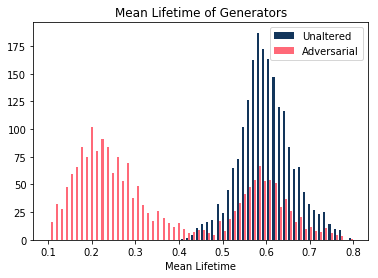

In [28]:
mls = [np.mean(l) for l in lifetimes]
adv_mls = [np.mean(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', range=[0.1,0.8], color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Mean Lifetime of Generators')
plt.xlabel('Mean Lifetime')

Text(0.5, 0, 'Median Lifetime')

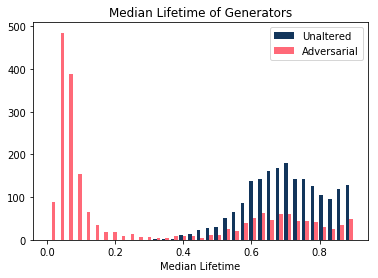

In [30]:
mls = [np.median(l) for l in lifetimes]
adv_mls = [np.median(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', range=[0,0.9], color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Median Lifetime of Generators')
plt.xlabel('Median Lifetime')

In [21]:
# for dgm in dgms:
#     dion.plot.plot_diagram(dgm, show=True)

In [22]:
# for adv_dgm in adv_dgms:
#     dion.plot.plot_diagram(adv_dgm, show=True)

In [23]:
# thru = 3
# all_gois = []
# for i in range(len(sample_graphs)):
#     print(i)
#     ks = list(sample_graphs[i].keys())
#     a = [sample_graphs[i][k] for k in ks[:thru]]
#     all_gois.append(nx.compose_all(a))
    
# adv_all_gois = []
# for i in range(len(adv_sample_graphs)):
#     print(i)
#     ks = list(adv_sample_graphs[i].keys())
#     a = [adv_sample_graphs[i][k] for k in ks[:thru]]
#     adv_all_gois.append(nx.compose_all(a))

In [24]:
kernel = 'linear'
take = -1
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [31]:
edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    lst = list(sample_graphs[i].keys())
    for k in lst[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 494/2000
Sample: 495/2000
Sample: 496/2000
Sample: 497/2000
Sample: 498/2000
Sample: 499/2000
Sample: 500/2000
Sample: 501/2000
Sample: 502/2000
Sample: 503/2000
Sample: 504/2000
Sample: 505/2000
Sample: 506/2000
Sample: 507/2000
Sample: 508/2000
Sample: 509/2000
Sample: 510/2000
Sample: 511/2000
Sample: 512/2000
Sample: 513/2000
Sample: 514/2000
Sample: 515/2000
Sample: 516/2000
Sample: 517/2000
Sample: 518/2000
Sample: 519/2000
Sample: 520/2000
Sample: 521/2000
Sample: 522/2000
Sample: 523/2000
Sample: 524/2000
Sample: 525/2000
Sample: 526/2000
Sample: 527/2000
Sample: 528/2000
Sample: 529/2000
Sample: 530/2000
Sample: 531/2000
Sample: 532/2000
Sample: 533/2000
Sample: 534/2000
Sample: 535/2000
Sample: 536/2000
Sample: 537/2000
Sample: 538/2000
Sample: 539/2000
Sample: 540/2000
Sample: 541/2000
Sample: 542/2000
Sample: 543/2000
Sample: 544/2000
Sample: 545/2000
Sample: 546/2000
Sample: 547/2000
Sample: 548/2000
Sample: 549/2000
Sample: 550/2000
Sample: 551/2000
Sample: 552/20

Sample: 981/2000
Sample: 982/2000
Sample: 983/2000
Sample: 984/2000
Sample: 985/2000
Sample: 986/2000
Sample: 987/2000
Sample: 988/2000
Sample: 989/2000
Sample: 990/2000
Sample: 991/2000
Sample: 992/2000
Sample: 993/2000
Sample: 994/2000
Sample: 995/2000
Sample: 996/2000
Sample: 997/2000
Sample: 998/2000
Sample: 999/2000
Sample: 1000/2000
Sample: 1001/2000
Sample: 1002/2000
Sample: 1003/2000
Sample: 1004/2000
Sample: 1005/2000
Sample: 1006/2000
Sample: 1007/2000
Sample: 1008/2000
Sample: 1009/2000
Sample: 1010/2000
Sample: 1011/2000
Sample: 1012/2000
Sample: 1013/2000
Sample: 1014/2000
Sample: 1015/2000
Sample: 1016/2000
Sample: 1017/2000
Sample: 1018/2000
Sample: 1019/2000
Sample: 1020/2000
Sample: 1021/2000
Sample: 1022/2000
Sample: 1023/2000
Sample: 1024/2000
Sample: 1025/2000
Sample: 1026/2000
Sample: 1027/2000
Sample: 1028/2000
Sample: 1029/2000
Sample: 1030/2000
Sample: 1031/2000
Sample: 1032/2000
Sample: 1033/2000
Sample: 1034/2000
Sample: 1035/2000
Sample: 1036/2000
Sample: 103

Sample: 1442/2000
Sample: 1443/2000
Sample: 1444/2000
Sample: 1445/2000
Sample: 1446/2000
Sample: 1447/2000
Sample: 1448/2000
Sample: 1449/2000
Sample: 1450/2000
Sample: 1451/2000
Sample: 1452/2000
Sample: 1453/2000
Sample: 1454/2000
Sample: 1455/2000
Sample: 1456/2000
Sample: 1457/2000
Sample: 1458/2000
Sample: 1459/2000
Sample: 1460/2000
Sample: 1461/2000
Sample: 1462/2000
Sample: 1463/2000
Sample: 1464/2000
Sample: 1465/2000
Sample: 1466/2000
Sample: 1467/2000
Sample: 1468/2000
Sample: 1469/2000
Sample: 1470/2000
Sample: 1471/2000
Sample: 1472/2000
Sample: 1473/2000
Sample: 1474/2000
Sample: 1475/2000
Sample: 1476/2000
Sample: 1477/2000
Sample: 1478/2000
Sample: 1479/2000
Sample: 1480/2000
Sample: 1481/2000
Sample: 1482/2000
Sample: 1483/2000
Sample: 1484/2000
Sample: 1485/2000
Sample: 1486/2000
Sample: 1487/2000
Sample: 1488/2000
Sample: 1489/2000
Sample: 1490/2000
Sample: 1491/2000
Sample: 1492/2000
Sample: 1493/2000
Sample: 1494/2000
Sample: 1495/2000
Sample: 1496/2000
Sample: 14

Sample: 1901/2000
Sample: 1902/2000
Sample: 1903/2000
Sample: 1904/2000
Sample: 1905/2000
Sample: 1906/2000
Sample: 1907/2000
Sample: 1908/2000
Sample: 1909/2000
Sample: 1910/2000
Sample: 1911/2000
Sample: 1912/2000
Sample: 1913/2000
Sample: 1914/2000
Sample: 1915/2000
Sample: 1916/2000
Sample: 1917/2000
Sample: 1918/2000
Sample: 1919/2000
Sample: 1920/2000
Sample: 1921/2000
Sample: 1922/2000
Sample: 1923/2000
Sample: 1924/2000
Sample: 1925/2000
Sample: 1926/2000
Sample: 1927/2000
Sample: 1928/2000
Sample: 1929/2000
Sample: 1930/2000
Sample: 1931/2000
Sample: 1932/2000
Sample: 1933/2000
Sample: 1934/2000
Sample: 1935/2000
Sample: 1936/2000
Sample: 1937/2000
Sample: 1938/2000
Sample: 1939/2000
Sample: 1940/2000
Sample: 1941/2000
Sample: 1942/2000
Sample: 1943/2000
Sample: 1944/2000
Sample: 1945/2000
Sample: 1946/2000
Sample: 1947/2000
Sample: 1948/2000
Sample: 1949/2000
Sample: 1950/2000
Sample: 1951/2000
Sample: 1952/2000
Sample: 1953/2000
Sample: 1954/2000
Sample: 1955/2000
Sample: 19

In [32]:
edf.head()

,437-891,374-972,375-834,213-576,572-547,622-594,209-597,1065-1060,801-465,488-662,...,347-184,573-543,381-889,488-656,294-965,488-407,429-898,569-453,292-268,319-573
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X = edf.values
y = res_df['class'].values

In [34]:
clf = svm.SVC( decision_function_shape='ovo', kernel=kernel)
cross_val_score(clf, X, y, cv=10)

array([0.95098039, 0.94607843, 0.95073892, 0.9408867 , 0.960199  ,
       0.92462312, 0.89447236, 0.94416244, 0.90306122, 0.93814433])

In [35]:
print('Natural performance: ', res_df[res_df['class'] == res_df['prediction']].shape[0]/res_df.shape[0])

Natural performance:  0.6595


In [36]:
t_fit = svm.SVC(decision_function_shape='ovo', kernel=kernel).fit(X,y)

In [37]:
# take = 3
# adv_edges = set()
# for i in range(len(adv_sample_graphs)):
#     for k in list(adv_sample_graphs[i].keys())[:take]:
#         for x in adv_sample_graphs[i][k].edges(data=True):
#             edge_name = str(x[0])+'-'+str(x[1])
#             adv_edges.add(edge_name)

In [38]:
adv_edf = pd.DataFrame(np.zeros((len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    lst = list(adv_sample_graphs[i].keys())
    for k in lst[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            if edge_name in adv_edf.columns:
                adv_edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 494/2000
Sample: 495/2000
Sample: 496/2000
Sample: 497/2000
Sample: 498/2000
Sample: 499/2000
Sample: 500/2000
Sample: 501/2000
Sample: 502/2000
Sample: 503/2000
Sample: 504/2000
Sample: 505/2000
Sample: 506/2000
Sample: 507/2000
Sample: 508/2000
Sample: 509/2000
Sample: 510/2000
Sample: 511/2000
Sample: 512/2000
Sample: 513/2000
Sample: 514/2000
Sample: 515/2000
Sample: 516/2000
Sample: 517/2000
Sample: 518/2000
Sample: 519/2000
Sample: 520/2000
Sample: 521/2000
Sample: 522/2000
Sample: 523/2000
Sample: 524/2000
Sample: 525/2000
Sample: 526/2000
Sample: 527/2000
Sample: 528/2000
Sample: 529/2000
Sample: 530/2000
Sample: 531/2000
Sample: 532/2000
Sample: 533/2000
Sample: 534/2000
Sample: 535/2000
Sample: 536/2000
Sample: 537/2000
Sample: 538/2000
Sample: 539/2000
Sample: 540/2000
Sample: 541/2000
Sample: 542/2000
Sample: 543/2000
Sample: 544/2000
Sample: 545/2000
Sample: 546/2000
Sample: 547/2000
Sample: 548/2000
Sample: 549/2000
Sample: 550/2000
Sample: 551/2000
Sample: 552/20

Sample: 981/2000
Sample: 982/2000
Sample: 983/2000
Sample: 984/2000
Sample: 985/2000
Sample: 986/2000
Sample: 987/2000
Sample: 988/2000
Sample: 989/2000
Sample: 990/2000
Sample: 991/2000
Sample: 992/2000
Sample: 993/2000
Sample: 994/2000
Sample: 995/2000
Sample: 996/2000
Sample: 997/2000
Sample: 998/2000
Sample: 999/2000
Sample: 1000/2000
Sample: 1001/2000
Sample: 1002/2000
Sample: 1003/2000
Sample: 1004/2000
Sample: 1005/2000
Sample: 1006/2000
Sample: 1007/2000
Sample: 1008/2000
Sample: 1009/2000
Sample: 1010/2000
Sample: 1011/2000
Sample: 1012/2000
Sample: 1013/2000
Sample: 1014/2000
Sample: 1015/2000
Sample: 1016/2000
Sample: 1017/2000
Sample: 1018/2000
Sample: 1019/2000
Sample: 1020/2000
Sample: 1021/2000
Sample: 1022/2000
Sample: 1023/2000
Sample: 1024/2000
Sample: 1025/2000
Sample: 1026/2000
Sample: 1027/2000
Sample: 1028/2000
Sample: 1029/2000
Sample: 1030/2000
Sample: 1031/2000
Sample: 1032/2000
Sample: 1033/2000
Sample: 1034/2000
Sample: 1035/2000
Sample: 1036/2000
Sample: 103

Sample: 1441/2000
Sample: 1442/2000
Sample: 1443/2000
Sample: 1444/2000
Sample: 1445/2000
Sample: 1446/2000
Sample: 1447/2000
Sample: 1448/2000
Sample: 1449/2000
Sample: 1450/2000
Sample: 1451/2000
Sample: 1452/2000
Sample: 1453/2000
Sample: 1454/2000
Sample: 1455/2000
Sample: 1456/2000
Sample: 1457/2000
Sample: 1458/2000
Sample: 1459/2000
Sample: 1460/2000
Sample: 1461/2000
Sample: 1462/2000
Sample: 1463/2000
Sample: 1464/2000
Sample: 1465/2000
Sample: 1466/2000
Sample: 1467/2000
Sample: 1468/2000
Sample: 1469/2000
Sample: 1470/2000
Sample: 1471/2000
Sample: 1472/2000
Sample: 1473/2000
Sample: 1474/2000
Sample: 1475/2000
Sample: 1476/2000
Sample: 1477/2000
Sample: 1478/2000
Sample: 1479/2000
Sample: 1480/2000
Sample: 1481/2000
Sample: 1482/2000
Sample: 1483/2000
Sample: 1484/2000
Sample: 1485/2000
Sample: 1486/2000
Sample: 1487/2000
Sample: 1488/2000
Sample: 1489/2000
Sample: 1490/2000
Sample: 1491/2000
Sample: 1492/2000
Sample: 1493/2000
Sample: 1494/2000
Sample: 1495/2000
Sample: 14

Sample: 1897/2000
Sample: 1898/2000
Sample: 1899/2000
Sample: 1900/2000
Sample: 1901/2000
Sample: 1902/2000
Sample: 1903/2000
Sample: 1904/2000
Sample: 1905/2000
Sample: 1906/2000
Sample: 1907/2000
Sample: 1908/2000
Sample: 1909/2000
Sample: 1910/2000
Sample: 1911/2000
Sample: 1912/2000
Sample: 1913/2000
Sample: 1914/2000
Sample: 1915/2000
Sample: 1916/2000
Sample: 1917/2000
Sample: 1918/2000
Sample: 1919/2000
Sample: 1920/2000
Sample: 1921/2000
Sample: 1922/2000
Sample: 1923/2000
Sample: 1924/2000
Sample: 1925/2000
Sample: 1926/2000
Sample: 1927/2000
Sample: 1928/2000
Sample: 1929/2000
Sample: 1930/2000
Sample: 1931/2000
Sample: 1932/2000
Sample: 1933/2000
Sample: 1934/2000
Sample: 1935/2000
Sample: 1936/2000
Sample: 1937/2000
Sample: 1938/2000
Sample: 1939/2000
Sample: 1940/2000
Sample: 1941/2000
Sample: 1942/2000
Sample: 1943/2000
Sample: 1944/2000
Sample: 1945/2000
Sample: 1946/2000
Sample: 1947/2000
Sample: 1948/2000
Sample: 1949/2000
Sample: 1950/2000
Sample: 1951/2000
Sample: 19

In [39]:
adv_preds = t_fit.predict(adv_edf.values)

In [40]:
adv_preds[:5]

array([7, 2, 2, 0, 4])

In [41]:
adv_df.head()

,class,loss,prediction
0,7,2.302585,0
1,2,2.302585,0
2,1,2.302585,0
3,0,2.210528,8
4,4,1.860150,9


In [42]:
print('Recovery Accuracy: {}'.format(adv_df[adv_df['class'] == adv_preds].shape[0]/adv_df.shape[0]))

Recovery Accuracy: 0.6245


In [43]:
print('Adversary Class Percentage: {}'.format(adv_df[adv_df['prediction'] == adv_preds].shape[0]/adv_df.shape[0]))

Adversary Class Percentage: 0.247


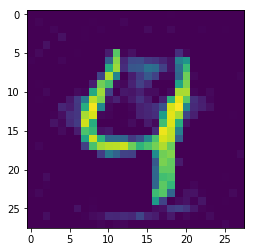

In [44]:
plt.imshow(adversaries[4]['adversary'].reshape(28,28))

In [45]:
adv_df['prediction'].value_counts()/adv_df.shape[0]

0    0.4235
8    0.2445
9    0.1295
4    0.0835
7    0.0585
6    0.0400
1    0.0205
Name: prediction, dtype: float64

In [46]:
adv_df[adv_df['class'] == adv_preds]['prediction'].value_counts()/adv_df[adv_df['class'] == adv_preds]['prediction'].shape[0]

0    0.503603
8    0.236189
9    0.116093
4    0.053643
7    0.045637
6    0.036829
1    0.008006
Name: prediction, dtype: float64

In [47]:
colors = ['black', 'blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'silver', 'cyan']
labels = list(range(10))

In [48]:
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import PyQt5

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)

# plt.cla()
# pca = PCA(n_components=3)
# pca.fit(X)
# X_pca = pca.transform(X)

# for i in range(len(X_pca)):
#     ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], color=colors[res_df['prediction'].iloc[i]])

In [49]:
# from sklearn import manifold
# from collections import OrderedDict

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)
# plt.cla()

# # X_dimmed = manifold.TSNE(n_components=3, init='pca', random_state=0).fit_transform(X)
# X_dimmed = manifold.Isomap(10, 3).fit_transform(X)

# for i in range(len(X_dimmed)):
#     ax.scatter(X_dimmed[i,0], X_dimmed[i,1], X_dimmed[i,2], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]])

# handles, labs = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labs, handles))
# ax.legend(by_label.values(), by_label.keys())

In [50]:
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict

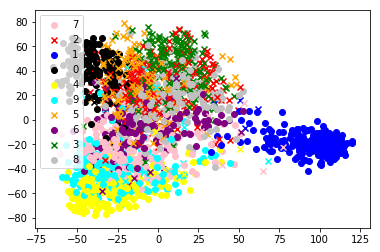

In [51]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i in range(len(X_pca)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

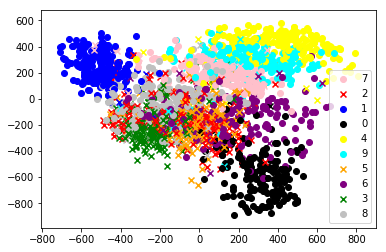

In [52]:
from sklearn import manifold
fig, ax = plt.subplots()
X_dimmed = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(X)
# X_dimmed = manifold.TSNE(n_components=2, init='pca', random_state=5).fit_transform(X)
# X_dimmed = manifold.SpectralEmbedding(n_neighbors=100, n_components=2).fit_transform(X)
# X_dimmed = manifold.MDS(2, max_iter=200, n_init=10).fit_transform(X)
# X_dimmed = manifold.LocallyLinearEmbedding(10, 2, eigen_solver='auto', method='standard').fit_transform(X)


for i in range(len(X_dimmed)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_dimmed[i,0], X_dimmed[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

In [53]:
classes = list(range(10))
avgs = []
for c in classes:
    avgs.append(edf.iloc[list(res_df[res_df['class'] == c].index)].mean(axis=0))
average_df = pd.DataFrame(avgs)

In [54]:
average_df.head(10)

,437-891,374-972,375-834,213-576,572-547,622-594,209-597,1065-1060,801-465,488-662,...,347-184,573-543,381-889,488-656,294-965,488-407,429-898,569-453,292-268,319-573
0,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057143,0.000000,0.000000,0.000000,0.685714,0.000000,0.000000,0.057143,0.057143,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.641026,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.709402,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.136986,0.136986,0.136986,0.000000,0.000000,0.045662,0.000000,0.000000,...,0.000000,0.045662,0.000000,0.136986,0.273973,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.048309,0.048309,1.980676,0.000000,0.000000,0.048309,0.000000,0.000000,0.000000,0.000000,...,0.144928,0.048309,0.000000,0.000000,3.285024,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.092166,0.783410,0.599078,0.138249,0.000000,0.000000,0.000000,0.000000,0.092166,...,0.138249,0.000000,0.000000,0.000000,0.138249,0.046083,0.276498,0.000000,0.046083,0.046083
5,0.000000,0.000000,2.960894,0.000000,0.111732,0.000000,0.055866,0.000000,0.000000,0.000000,...,0.111732,0.000000,0.000000,0.055866,1.508380,0.000000,0.000000,0.000000,0.167598,0.000000
6,0.000000,0.000000,0.730337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.168539,0.000000,0.000000,0.000000,0.617978,0.000000,0.000000,0.000000,0.056180,0.000000
7,0.000000,0.000000,0.341463,0.000000,0.829268,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.097561,0.000000,0.000000,0.000000,0.195122,0.000000
8,0.000000,0.000000,2.031250,0.000000,0.520833,0.000000,0.000000,0.000000,0.052083,0.000000,...,0.052083,0.000000,0.000000,0.052083,0.677083,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.103093,1.134021,0.051546,0.309278,0.000000,0.000000,0.000000,0.000000,0.051546,...,0.051546,0.000000,0.051546,0.000000,0.463918,0.000000,0.206186,0.000000,0.000000,0.000000


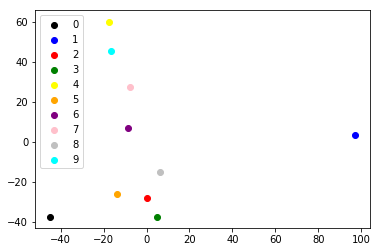

In [55]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(average_df.values)

for i in range(len(X_pca)):
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[i], label=labels[i])
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

In [56]:
import scipy
inps = np.zeros((average_df.shape[0], average_df.shape[0]))
for i in range(inps.shape[0]):
    for j in range(inps.shape[0]):
        inps[i,j] = 1-scipy.spatial.distance.cosine(average_df.iloc[i], average_df.iloc[j])

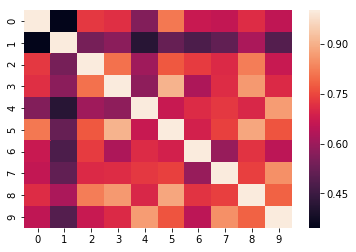

In [57]:
sns.heatmap(inps)